In [1]:
import warnings

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Input, Lambda, Embedding, GRU, Bidirectional, Concatenate, Dense
)
from tensorflow.keras.regularizers import L1L2
import numpy as np
import pandas as pd

import nltk
import gensim.downloader
import re
from calendar import day_name, day_abbr, month_name, month_abbr
from collections import Counter

from sklearn import preprocessing
from sklearn.utils import class_weight
# from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

In [2]:
# constants that will be used as tokens
PAD = '~PAD~'
URL = '~URL~'
DATETIME = '~DATETIME~'
QUANTITY = '~QUANTITY~'
NUM = '~NUM~'
UNK = '~UNK~'

# regexes to be applied prior to tokenization
url_regex = '(www\.|http://|https://)\S+|\S+\.(co|org|net|info|be|gov|edu|html|jpg|jpeg|png|gif)'
date_regex = '('        + '|'.join(day_name[i] for i in range(7)) +\
             '|'        + '|'.join(day_abbr[i] for i in range(7)) +\
             ')?,?\s?(' + '|'.join(month_name[i] for i in range(1, 13)) +\
             '|'        + '|'.join(month_abbr[i] for i in range(1, 13)) +\
             ")\s\d{1,2}(st|nd|rd|th)?(,?\s'?\d{2,4})?"
time_regex = '((\d+\:\d+)(\s?[AaPp]\.\s?[Mm]\.)?)|((\d+\:\d+\s?)?([AaPp]\.\s?[Mm]\.))'
quantity_regex = '\d+((\,?\d+)+)?'

# list of stopwords
stopwords = nltk.corpus.stopwords.words('english')

### HYPERPARAMETERS ###
PERCENT_TEST = 0.075
PERCENT_VAL  = 0.075

### RANDOM SEED (for reproducibility) ###
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

In [3]:
%%time

# download our pretrained word embedding with embedding size of 300
EMBED_SIZE = 300
gn300_raw = gensim.downloader.load('word2vec-google-news-300')

"""
Condense our pretrained word embedding using the following two techniques:
1) remove stopwords
2) make all keys lowercase, group by key, and take average per key.
E.g. (gn300_raw['beyonce'] +
      gn300_raw['Beyonce'] +
      gn300_raw['BEYONCE']) / 3 -> gn300['beyonce']
"""
S = Counter() # vector sum
C = Counter() # vector count
for word in gn300_raw.vocab:
    lower = word.lower()
    if lower in stopwords: continue
    S[lower] += gn300_raw[word]
    C[lower] += 1
# create condensed word2vec (just a simple dictionary)
gn300 = {w: s / c for w, s, c in zip(S.keys(), S.values(), C.values())}

CPU times: user 55.9 s, sys: 3.19 s, total: 59.1 s
Wall time: 1min 1s


In [4]:
# get data
news = pd.read_csv('fake-news/train.csv')
news = news[['title','text','label']]
news = news.dropna()
news = news.sample(frac=1, random_state=RANDOM_SEED)

# binarize labels
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(news.label)

# split between test and training/validation data
test_size = int(PERCENT_TEST * len(news))
train, y_train = news.iloc[test_size:].copy(deep=True), y[test_size:]
test, y_test = news.iloc[:test_size].copy(deep=True), y[:test_size]

# Expected result of validation_split. This is just to give us a sense
# of the distribution of labels.
def display_count(df):
    print(len(df[df.label == 0]), len(df[df.label == 1]))
display_count(train.iloc[:-int(PERCENT_VAL * len(news))])
display_count(train.iloc[-int(PERCENT_VAL * len(news)):])
display_count(test)

8820 8353
771 744
796 719


In [5]:
%%time

# e.g. split_by_case('ILoveNewYork') == ['I', 'Love', 'New', 'York']
def split_by_case(s):
    if (not s[1:].isupper()) and (not s[1:].islower()):
        for i in range(1, len(s) - 1):
            if s[i].isupper():
                return [s[:i]] + split_by_case(s[i:])
            elif s[i + 1].isupper():
                return [s[:i + 1]] + split_by_case(s[i + 1:])
    return [s]

def supertokenize(text):
    text = re.sub(quantity_regex, QUANTITY, 
                 re.sub(time_regex, DATETIME, 
                        re.sub(date_regex, DATETIME, 
                               re.sub(url_regex, URL, text))))
    text = text.replace('•', '')
    raw_tokens = nltk.word_tokenize(text)
    tokens = []
    for t in raw_tokens:
        if t in '!"\'(),--./:;<?[\\]{|}“”‘’—': continue
        if t.lower() != "n't": t = re.sub('[\"\']', '', t)
        if (len(t) > 2) and (t.lower() == t) and (t[-1] == '.'): t = t[:-1]
        if t == URL:
            tokens.append(URL)
            continue
        if (t == DATETIME) or (re.sub('^\d+(/\d+)+$', '', t) == ''):
            tokens.append(DATETIME)
            continue
        if t == QUANTITY:
            tokens.append(QUANTITY)
            continue
        if t.isnumeric() or (t[:-2].isnumeric() and (t[-2:] in ['st', 'nd', 'rd', 'th'])):
            tokens.append(NUM)
            continue
        t = t.lower()
        if t in stopwords: continue
        if t in gn300:
            tokens.append(t)
        else:
            if t + '.' in gn300:
                tokens.append(t + '.')
                continue
            if t.replace('.', '') in gn300:
                tokens.append(t.replace('.', ''))
                continue
            is_found = False
            for x in split_by_case(re.sub('[^a-z]', '', t)):
                if x in gn300:
                    tokens.append(x)
                    is_found = True
            if is_found: continue
            for st in re.split('-', re.sub('[^a-z0-9\.~]', '-', t)):
                for x in [st, st[:-1], st[1:], st.replace('s', 'z'), 
                          st.replace('ou', 'o'), st.replace('re', 'er')]:
                    if x in gn300:
                        tokens.append(x)
                        is_found = True
                        break
            if not is_found: tokens.append(UNK)
    return tokens

# this does tokenization as well as tracking token counts grouped by label
def supertokenizeplus(text, label):
    global tc_real, tc_fake
    tokens = supertokenize(text)
    tc = Counter(tokens)
    if label in [0, 'REAL']:
        tc_fake += tc
    elif label in [1, 'FAKE']:
        tc_real += tc
    else:
        warnings.warn('Unexpected label %s'.format(label))
    return tokens

tc_real=Counter()
tc_fake=Counter()
train['tokenized_title'] = train.apply(lambda x: supertokenizeplus(x.title, x.label), axis=1)
train['tokenized_text'] = train.apply(lambda x: supertokenizeplus(x.text, x.label), axis=1)

CPU times: user 4min 45s, sys: 278 ms, total: 4min 45s
Wall time: 4min 45s


In [7]:
t = Counter()
for k in tc_real + tc_fake:
    t[k] = abs(tc_real[k] - tc_fake[k]) / np.sqrt(tc_real[k] + tc_fake[k])

thresh = t.most_common(25000)[-1][1]
tokens = [k for k, v in t.items() if v >= thresh]

vocab, i = {PAD: 0, URL: 1, DATETIME: 2, QUANTITY: 3, NUM: 4, UNK: 5}, 6
for w in tokens:
    if w in (PAD, URL, DATETIME, QUANTITY, NUM, UNK): continue
    vocab[w] = i
    i += 1
id2word = {v: k for k, v in vocab.items()}

i, t.most_common(10)

(25041,
 [('~UNK~', 300.76179282734165),
  ('mr.', 235.2116532892824),
  ('said', 192.0781204635688),
  ('ms.', 103.77900147969193),
  ('~QUANTITY~', 101.01247607174403),
  ('hillary', 87.32835839338703),
  ('york', 84.86174512966578),
  ('new', 77.44751235523478),
  ('breitbart', 72.85725040861652),
  ('s.', 69.83259678225906)])

In [8]:
%%time
test['tokenized_title'] = test.apply(lambda x: supertokenize(x.title),axis=1)
test['tokenized_text'] = test.apply(lambda x: supertokenize(x.text),axis=1)

CPU times: user 17.2 s, sys: 27.9 ms, total: 17.2 s
Wall time: 17.2 s


In [9]:
def clean(text,length):
    f = [vocab[w] if w in vocab else vocab[UNK] for w in text]
    f = f[:length]
    return (length - len(f)) * [vocab[PAD]] + f
train['text_as_ints'] = train.tokenized_text.apply(clean,args=[512])
train['title_as_ints'] = train.tokenized_text.apply(clean,args=[64])
test['text_as_ints'] = test.tokenized_text.apply(clean,args=[512])
test['title_as_ints'] = test.tokenized_text.apply(clean,args=[64])

X_train = [np.array(train.text_as_ints.to_list()), np.array(train.title_as_ints.to_list())]
X_test = [np.array(test.text_as_ints.to_list()), np.array(test.title_as_ints.to_list())]

In [10]:
input_text = Input(shape=[None])
input_title = Input(shape=[None])
mask = Lambda(lambda inputs: K.not_equal(inputs, 0))
def emb():
    e = np.zeros((len(vocab), EMBED_SIZE))
    v = np.random.uniform(-1, 1, EMBED_SIZE)
    for i in range(len(vocab)):
        try:
            g = gn300[id2word[i]]
            e[i] = g + v * np.linalg.norm(g) / np.linalg.norm(v)
        except KeyError:
            assert i <= 5, i
            if i in [1, 2, 3, 4]: # leave PAD and UNK zero
                e[i] = v / np.linalg.norm(v)
    return Embedding(input_dim=e.shape[0],
                     output_dim=e.shape[1],
                     weights=[e],
                     trainable=False)
emb_text = emb()(input_text)
emb_title = emb()(input_title)
gru = lambda: GRU(50, dropout=0.2, recurrent_dropout=0.2,
                  kernel_regularizer=L1L2(l1=1e-6, l2=2e-6))
gru_text = Bidirectional(gru())(emb_text, mask=mask(input_text))
gru_title = gru()(emb_title, mask=mask(input_title))
concat = Concatenate()([gru_text, gru_title])
outputs = Dense(1, activation='sigmoid')(concat)
model = tf.keras.Model(inputs=[input_text, input_title], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    7512300     input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]                

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(X_train, y_train, epochs=1, batch_size=64)

292/292 [==============================] - 226s 761ms/step - loss: 0.4954 - accuracy: 0.7535


In [12]:
for i in range(len(model.layers)):
    model.layers[i].trainable = False
    if i in [2, 4]:
        model.layers[i].trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    7512300     input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]                

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(X_train, y_train, epochs=1, batch_size=64)

292/292 [==============================] - 212s 713ms/step - loss: 0.1633 - accuracy: 0.9408


In [14]:
for i in range(len(model.layers)):
    model.layers[i].trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    7512300     input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]                

In [15]:
from sklearn.utils import class_weight
model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics='accuracy')
validation_split = PERCENT_VAL / (1 - PERCENT_TEST)
checkpoint_filepath = '/tmp/checkpoint_v0'
class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1],
                                                  y=[w for x in y_train for w in x])
class_weights = {i: weight for i, weight in enumerate(class_weights)}
model.fit(
    X_train, y_train, validation_split=validation_split, epochs=10, batch_size=32,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )], class_weight=class_weights
)

Epoch 1/10
537/537 [==============================] - 406s 745ms/step - loss: 0.0689 - accuracy: 0.9809 - val_loss: 0.0412 - val_accuracy: 0.9921
Epoch 2/10
537/537 [==============================] - 399s 744ms/step - loss: 0.0197 - accuracy: 0.9976 - val_loss: 0.2320 - val_accuracy: 0.9307
Epoch 3/10
537/537 [==============================] - 400s 746ms/step - loss: 0.0152 - accuracy: 0.9984 - val_loss: 0.0382 - val_accuracy: 0.9927
Epoch 4/10
537/537 [==============================] - 390s 726ms/step - loss: 0.0109 - accuracy: 0.9997 - val_loss: 0.0369 - val_accuracy: 0.9941
Epoch 5/10
537/537 [==============================] - 384s 715ms/step - loss: 0.0089 - accuracy: 0.9999 - val_loss: 0.0398 - val_accuracy: 0.9914
Epoch 6/10
537/537 [==============================] - 383s 714ms/step - loss: 0.0076 - accuracy: 0.9999 - val_loss: 0.0371 - val_accuracy: 0.9921
Epoch 7/10
537/537 [==============================] - 383s 714ms/step - loss: 0.0349 - accuracy: 0.9954 - val_loss: 0.0514 -

In [16]:
model.load_weights(checkpoint_filepath)
logits = model.predict(X_test)
most_off = np.argmax(np.abs(y_test - logits))
print(y_test[most_off], logits[most_off])
test.iloc[most_off].title, test.iloc[most_off].text

[1] [5.0615727e-06]


('Planned Parenthood: Abortion pill usage now rivals surgery',
 "Planned Parenthood: Abortion pill usage now rivals surgery October 31, 2016 The Planned Parenthood logo is pictured outside a clinic in Boston, Massachusetts, June 27, 2014. REUTERS/Dominick Reuter \nAbortion pill usage has almost overtaken surgical alternatives as legalization of infanticide faces a major chance of repeal. in election 2016. Two medications used to induce abortion won US approval in 2000, but Pro-Life activists successfully implemented legislative restrictions. In 2014: Abortion medication was used in 43 percent of pregnancy terminations at Planned Parenthood clinics. in 2010: Up from 35 percent according to previously unreported figures by Planned Parenthood. In Ohio, Texas and North Dakota: Demand for medication abortions tripled in the last several months to as much as 30 percent of all procedures in some clinics. States with no restrictions: Up to 55 percent in Michigan, 64 percent in Iowa. Studies: D

In [17]:
y_pred = np.round(logits)
print(matthews_corrcoef(y_test, y_pred))
model.evaluate(X_test, y_test)

0.9457528106739049
48/48 [==============================] - 4s 93ms/step - loss: 0.1129 - accuracy: 0.9729


[0.11294664442539215, 0.972937285900116]

In [18]:
def get_reshaped_weights(model,layer_id):
    W=np.array(model.layers[layer_id].get_weights())
    W=W.reshape(W.shape[1],W.shape[2])
    return W
text_embed = get_reshaped_weights(model,2)
title_embed = get_reshaped_weights(model,4)

<ipython-input-19-92e1c33b0327>:8: RuntimeWarning: invalid value encountered in true_divide
  cs = W.dot(b) / (np.linalg.norm(W, axis=1) * np.linalg.norm(b))
<ipython-input-19-92e1c33b0327>:4: RuntimeWarning: invalid value encountered in greater_equal
  n_ = np.sum(arr >= thresh)


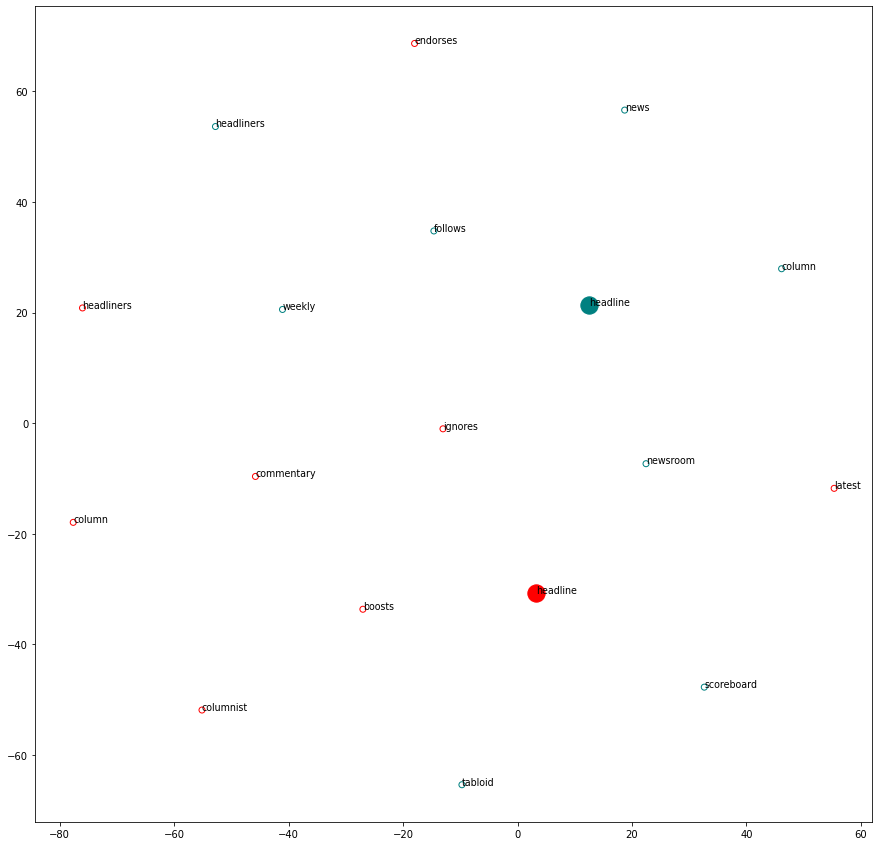

In [19]:
def get_top_n_plus_ties(arr, n):
    sorted_args = np.argsort(-arr)
    thresh = arr[sorted_args[n]]
    n_ = np.sum(arr >= thresh)
    return sorted_args[:n_]
def get_most_similar(word, W, n):
    b = W[vocab[word]]
    cs = W.dot(b) / (np.linalg.norm(W, axis=1) * np.linalg.norm(b))
    return get_top_n_plus_ties(cs, n)
def create_words_plot(embed1, embed2, WORD, k=9):
    ids1 = get_most_similar(WORD, embed1, k-1)
    ids2 = get_most_similar(WORD, embed2, k-1)
    words1 = [id2word[i] for i in ids1]
    words2 = [id2word[i] for i in ids2]
    v = TSNE(n_components=2,random_state=RANDOM_SEED).fit_transform(
        np.concatenate([embed1[ids1],embed2[ids2]]))
    fig = plt.figure(figsize=(15,15))
    plt.scatter(v[:k,0],v[:k,1],facecolors='none',edgecolors='teal')
    plt.scatter(v[k:,0],v[k:,1],facecolors='none',edgecolors='red')
    for i, word in enumerate(words1):
        plt.annotate(word,(v[i,0],v[i,1]),size=9.5)
        if word == WORD:
            plt.scatter(v[i,0],v[i,1],c='teal',s=300)
    for i, word in enumerate(words2):
        plt.annotate(word,(v[i+k,0],v[i+k,1]),size=9.5)
        if word == WORD:
            plt.scatter(v[i+k,0],v[i+k,1],c='red',s=300)
create_words_plot(text_embed,title_embed,'headline')